<a href="https://colab.research.google.com/github/KangGao1997/NeuroAI_project/blob/main/Neuro_AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [ ]:
dat['run'].shape

(7018, 1)

In [ ]:
dat['xyz'].shape
x, y, z = dat['xyz']

In [ ]:
z

array([-150., -150., -150., ..., -390., -390., -390.])

In [ ]:
zunq, iunq = np.unique(z, return_inverse=True)
zunq,iunq

(array([-390., -360., -330., -300., -270., -240., -210., -180., -150.]),
 array([8, 8, 8, ..., 0, 0, 0]))

<ipython-input-11-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


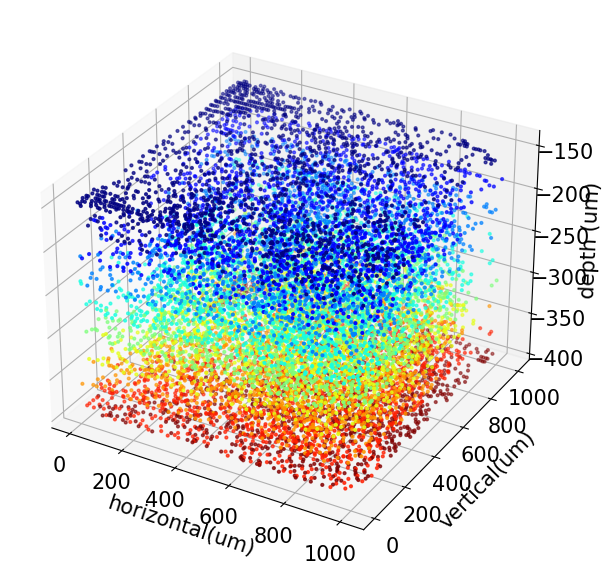

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

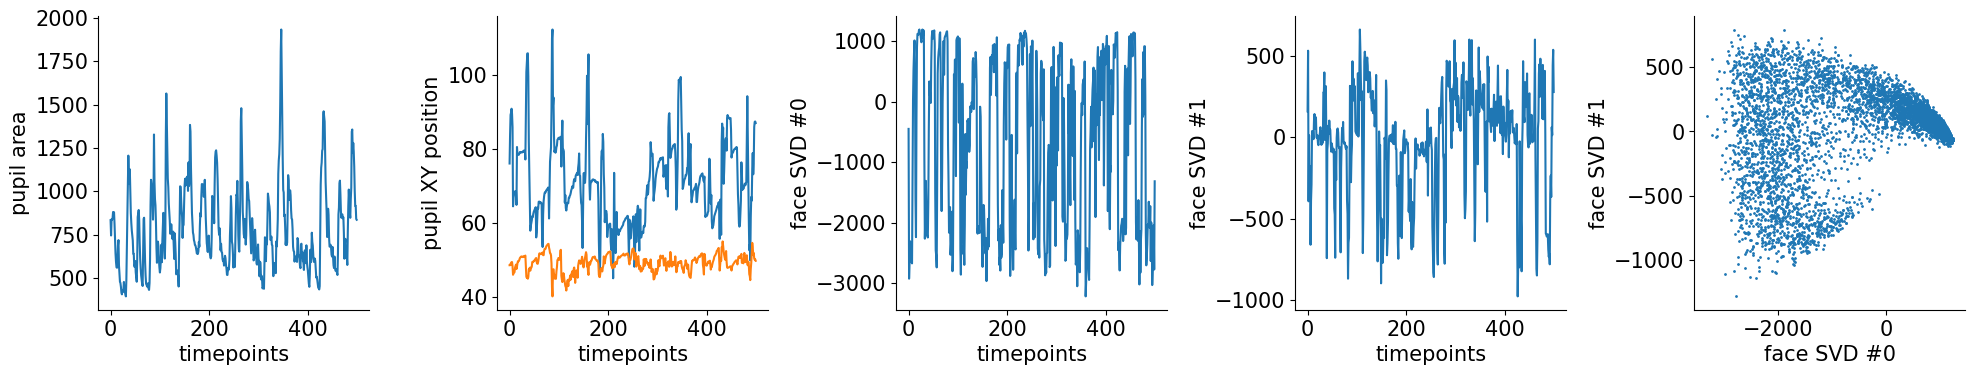

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

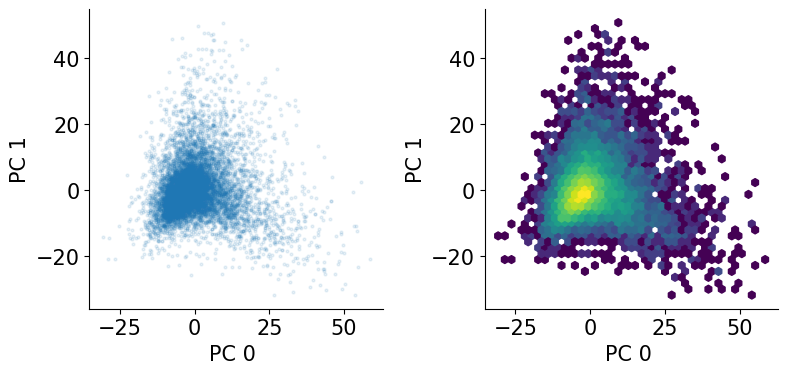

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

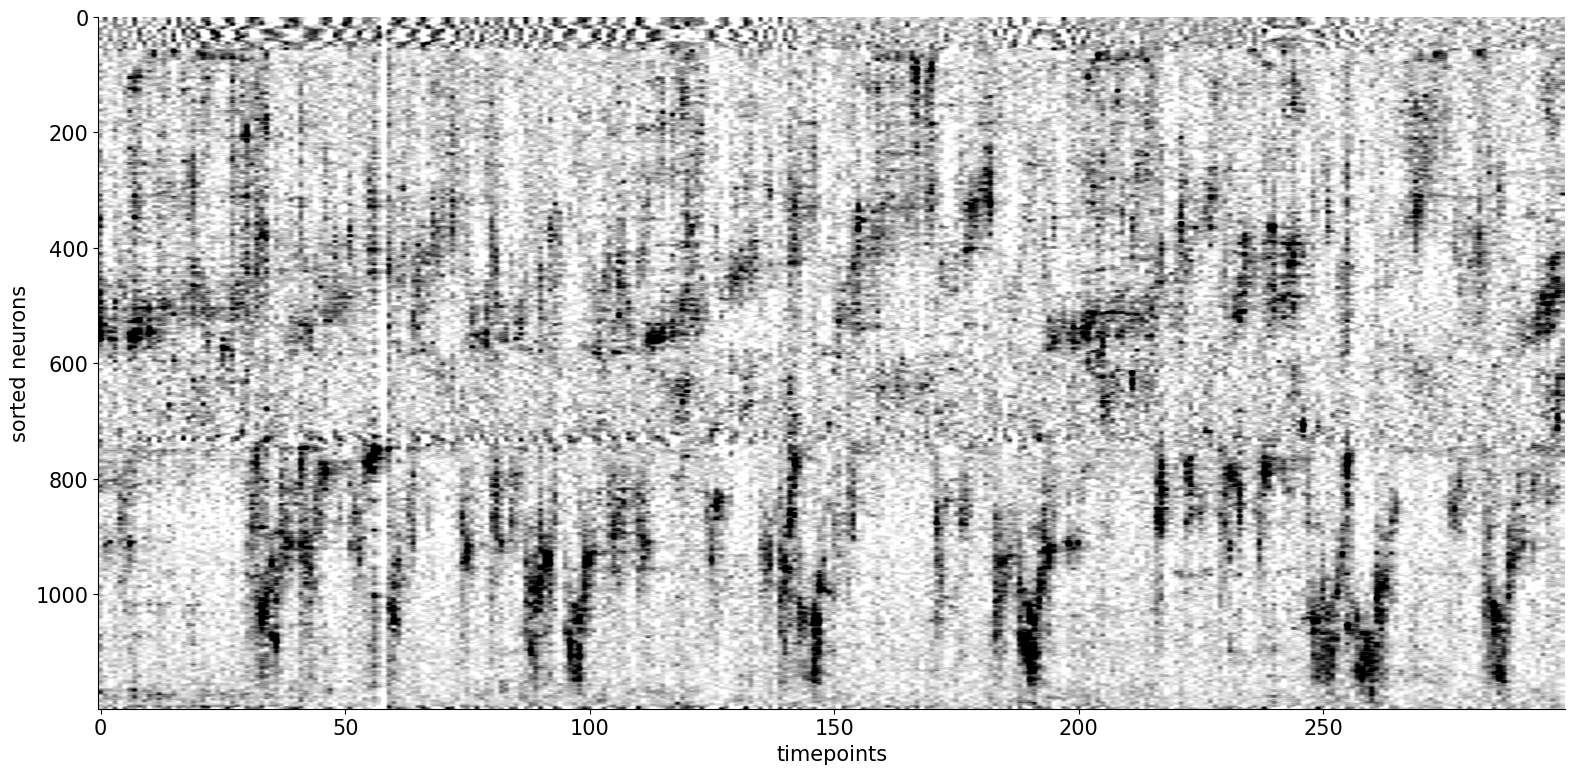

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture

# play around with pupil area

In [ ]:
# what is the shape/size/format of neural activity?

dat['sresp'].shape

(11983, 7018)

In [ ]:
dat['pupilArea'].shape

(7018, 1)

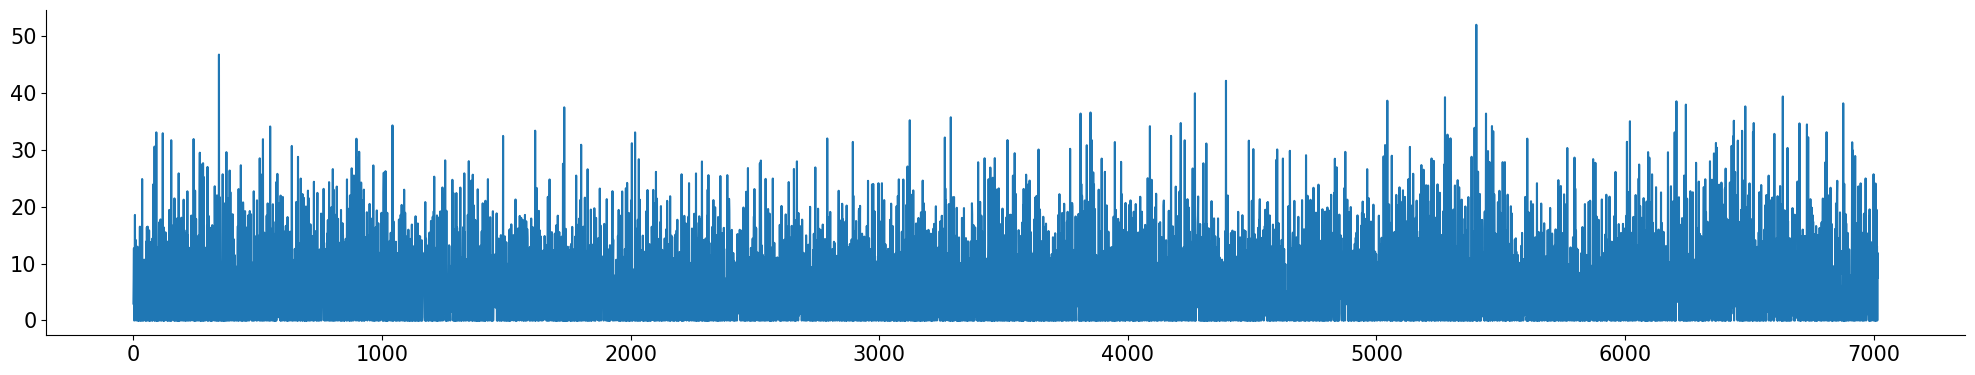

In [ ]:
plt.plot(dat['sresp'][0])

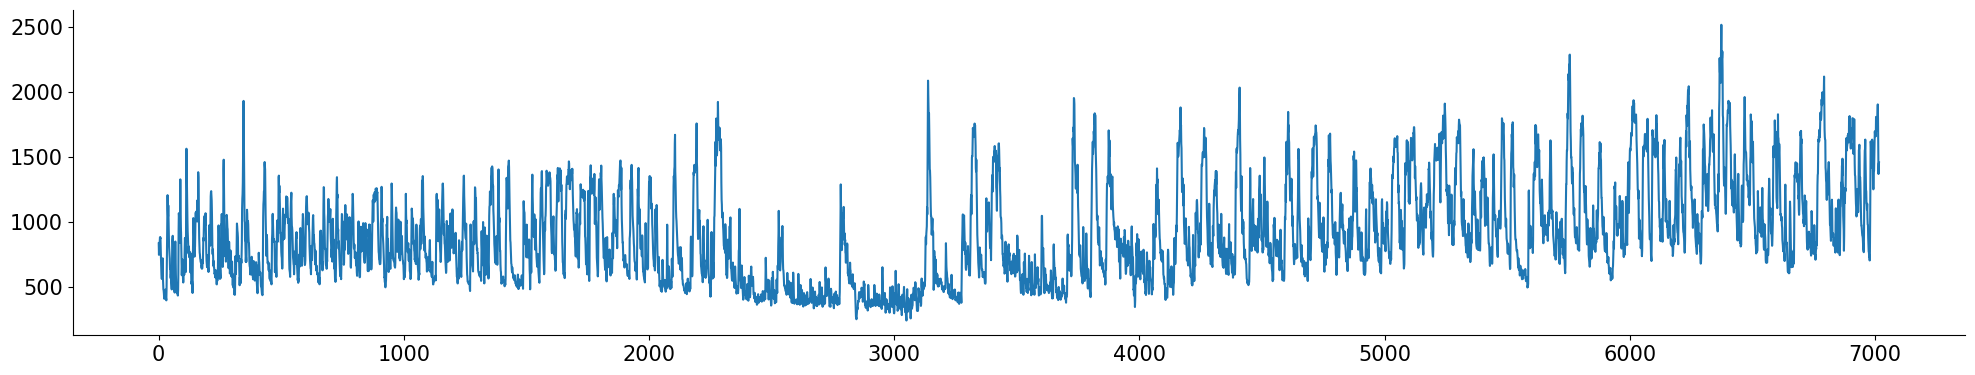

In [ ]:
plt.plot(dat['pupilArea'])

## Train a linear regressor

In [ ]:
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
train_neural_activity = dat['sresp'][:,0:5000].T
train_pupil_area = dat['pupilArea'][0:5000]
train_neural_activity.shape, train_pupil_area.shape

((5000, 11983), (5000, 1))

In [ ]:
Scaler = StandardScaler()
train_pupil_area =  Scaler.fit_transform(train_pupil_area)

In [ ]:
linear_decoder_pupilArea = Pipeline([('Scaler',StandardScaler()),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
linear_decoder_pupilArea = linear_decoder_pupilArea.fit(train_neural_activity,train_pupil_area)

### test on training dataset

In [ ]:
pred_train_pupil_area = linear_decoder_pupilArea.predict(train_neural_activity)

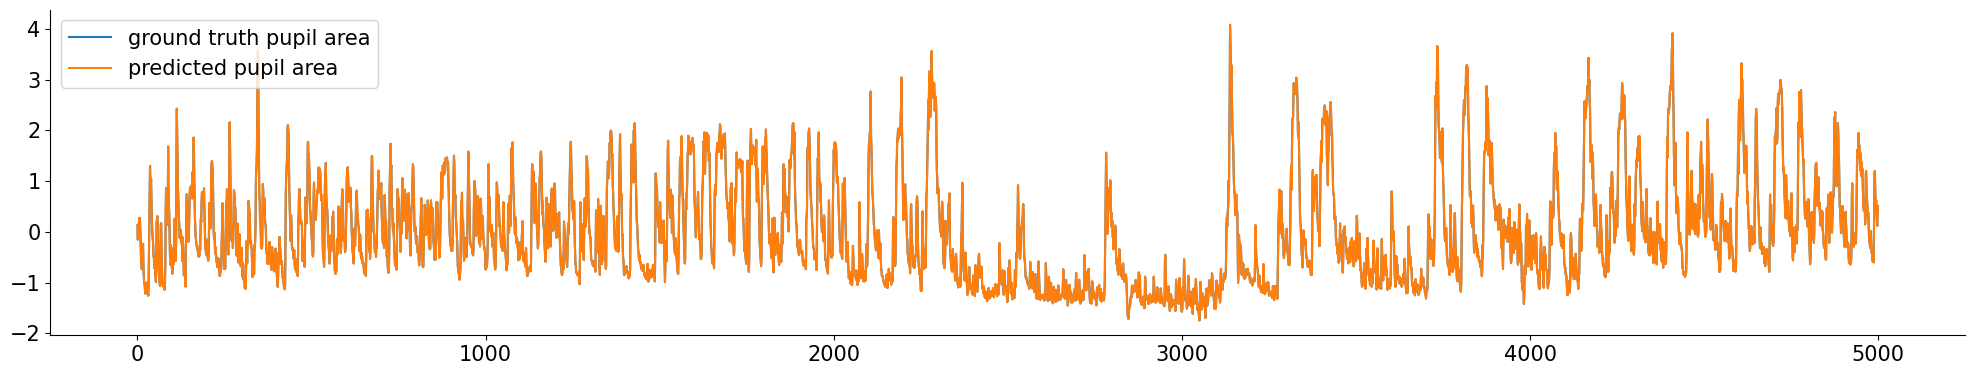

In [ ]:
plt.figure()
plt.plot(train_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_train_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print("mean square error on training dataset: ", mean_squared_error(pred_train_pupil_area,train_pupil_area))

mean square error on training dataset:  7.158900023691273e-12


### test on testing dataset

In [ ]:
test_neural_activity = dat['sresp'][:,5000:].T
test_pupil_area = dat['pupilArea'][5000:]
test_neural_activity.shape, test_pupil_area.shape

((2018, 11983), (2018, 1))

In [ ]:
test_pupil_area = Scaler.transform(test_pupil_area)

In [ ]:
pred_test_pupil_area = linear_decoder_pupilArea.predict(test_neural_activity)

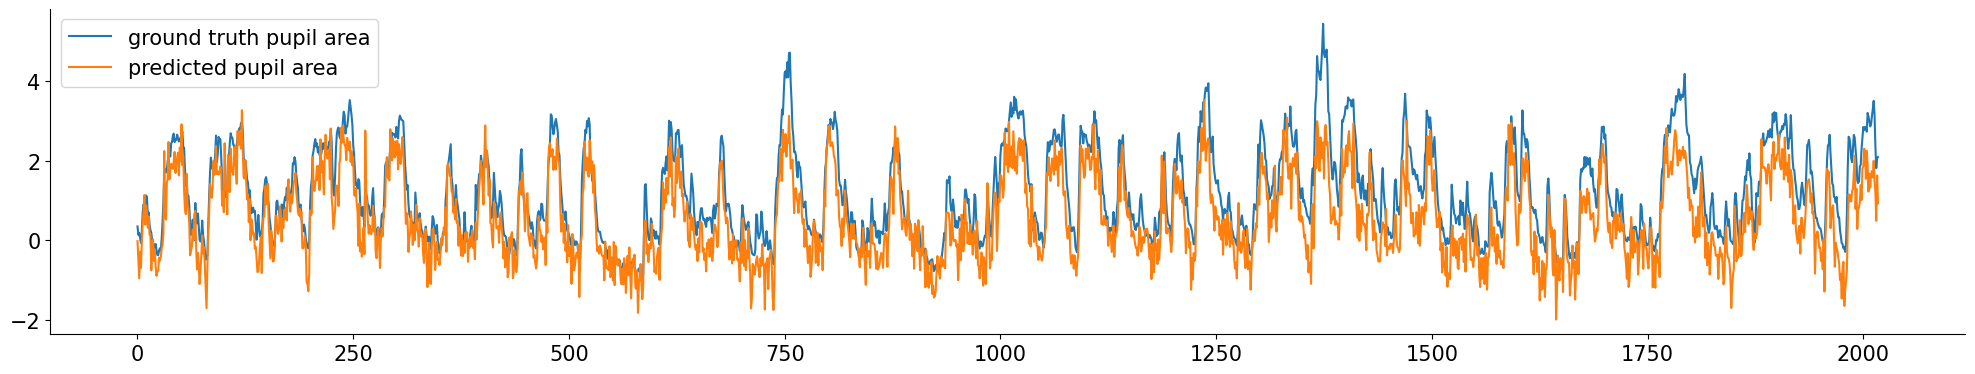

In [ ]:
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
print("mean square error on training dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

mean square error on training dataset:  0.6347932462984759


The performance is not very good, seems like overfitting

## Train a Ridge regressor

In [ ]:
ridge_decoder_pupilArea = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

In [ ]:
#ridge_decoder_pupilArea.fit(train_neural_activity,train_pupil_area)

ridge_decoder_pupilArea.get_params()

{'memory': None,
 'steps': [('Scaler', StandardScaler()), ('ridge_regressor', Ridge())],
 'verbose': False,
 'Scaler': StandardScaler(),
 'ridge_regressor': Ridge(),
 'Scaler__copy': True,
 'Scaler__with_mean': True,
 'Scaler__with_std': True,
 'ridge_regressor__alpha': 1.0,
 'ridge_regressor__copy_X': True,
 'ridge_regressor__fit_intercept': True,
 'ridge_regressor__max_iter': None,
 'ridge_regressor__positive': False,
 'ridge_regressor__random_state': None,
 'ridge_regressor__solver': 'auto',
 'ridge_regressor__tol': 0.0001}

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'ridge_regressor__alpha': [1300,1400,1500]}
Ridge_pupil_area_gs = GridSearchCV(ridge_decoder_pupilArea,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)

Ridge_pupil_area_gs.fit(train_neural_activity,train_pupil_area)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
Ridge_pupil_area_gs.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

In [ ]:
Ridge_decoder_pupilArea = Ridge_pupil_area_gs.best_estimator_


### Testing on train Dataset

In [ ]:
pred_train_pupil_area = Ridge_decoder_pupilArea.predict(train_neural_activity)

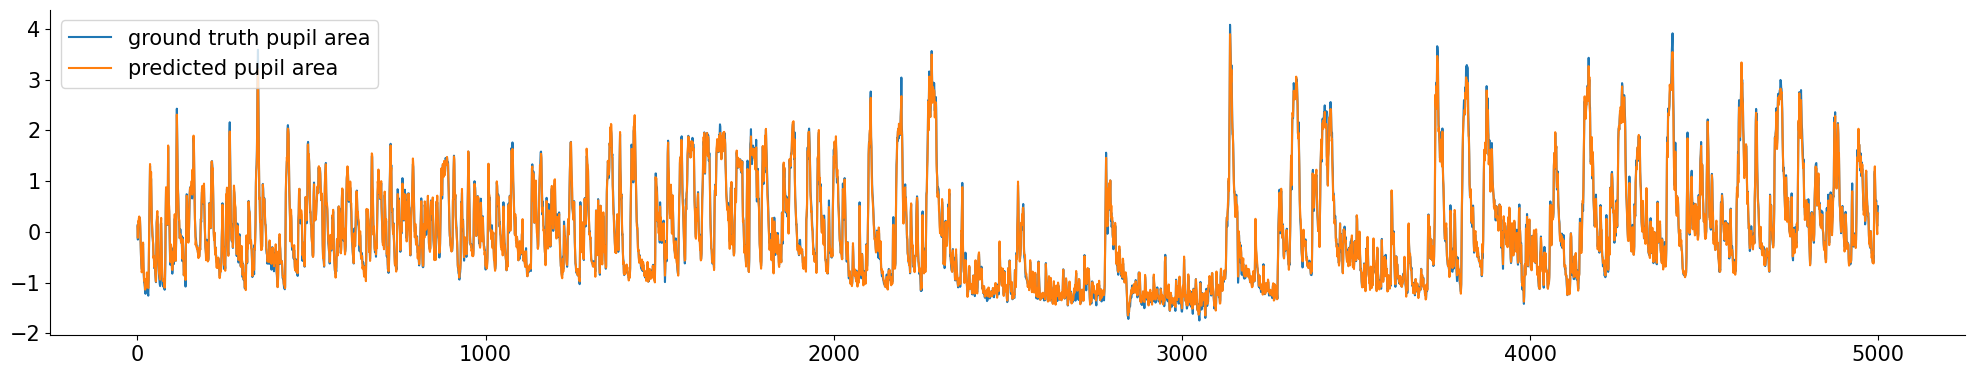

In [ ]:
plt.figure()
plt.plot(train_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_train_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
print("mean square error on testing dataset: ", mean_squared_error(pred_train_pupil_area,train_pupil_area))

mean square error on testing dataset:  0.004541158243863491


### Test on Testing dataset

In [ ]:
pred_test_pupil_area = Ridge_decoder_pupilArea.predict(test_neural_activity)

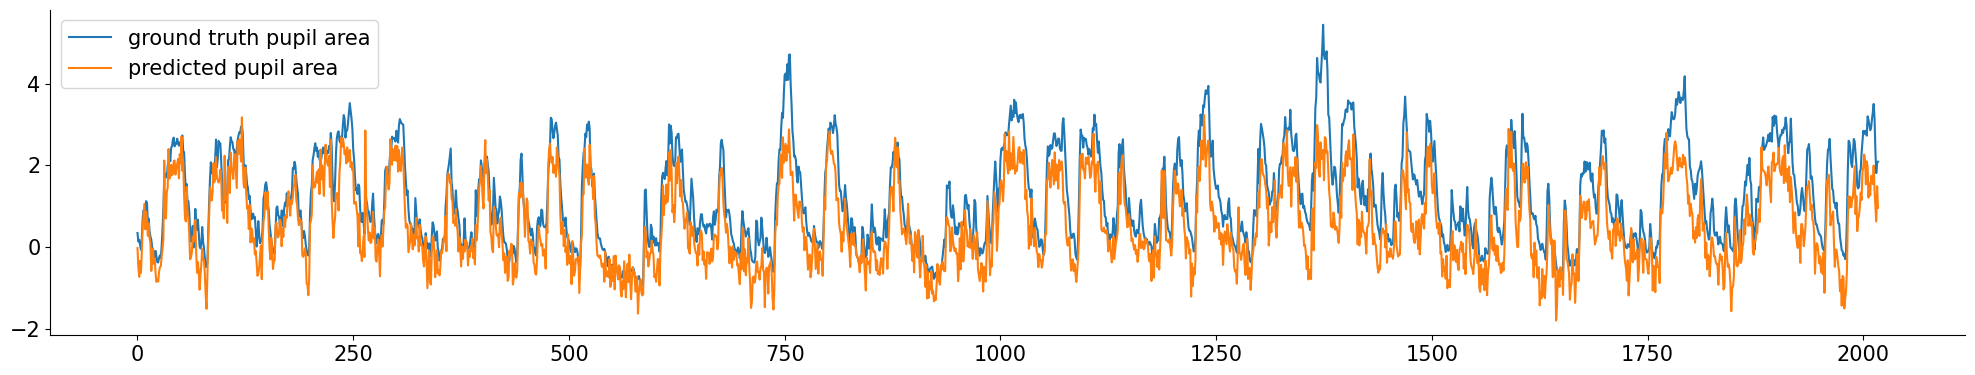

In [ ]:

plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

mean square error on testing dataset:  0.619636162280601


In [ ]:
w = Ridge_decoder_pupilArea.named_steps['ridge_regressor'].coef_.T
np.mean(w)+np.std(w)

0.0023876117

In [ ]:
dat['xyz'].T.shape

(11983, 3)

<ipython-input-50-f426359b7189>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


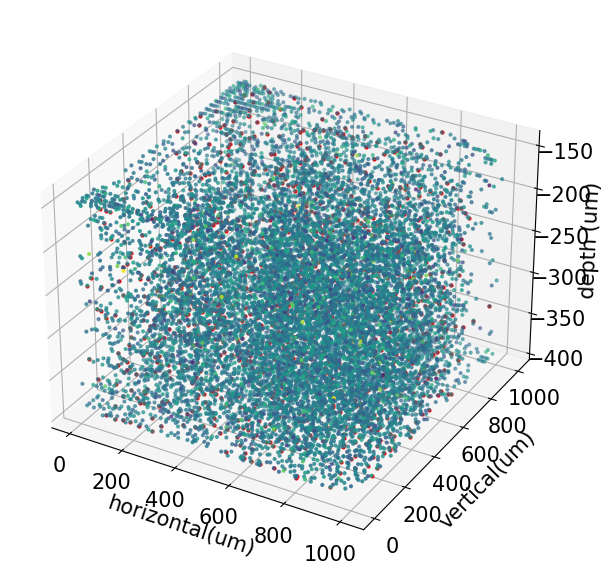

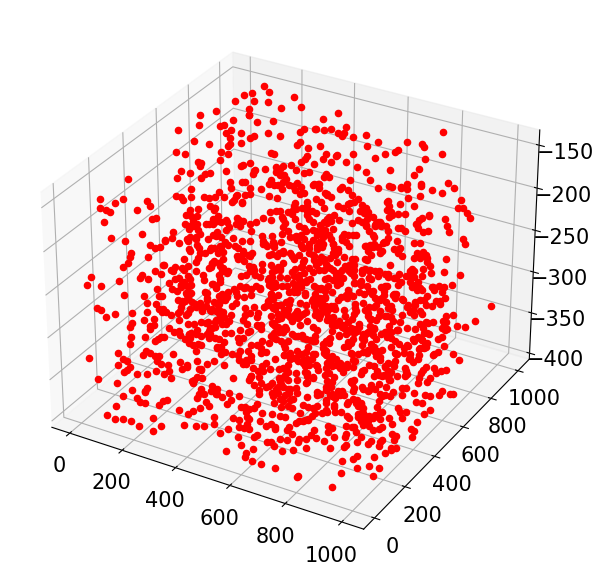

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0, 1.0, len(w))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=w)
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')

for i in range(w.shape[0]):
  if w[i]>(np.mean(w) + np.std(w)):
    ax.scatter(x[i],y[i], z[i], 'o', s=4, c='r')
#plt.colorbar()
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(w.shape[0]):
  if w[i]>(np.mean(w) + np.std(w)):
    ax.scatter(x[i],y[i], z[i], c = 'r')
plt.show()

### Explore different depth

In [ ]:
np.unique(dat['xyz'][2],return_counts = False, return_index = True)

(array([-390., -360., -330., -300., -270., -240., -210., -180., -150.]),
 array([10597,  9157,  7739,  6268,  4853,  3532,  2314,  1131,     0]))

There are 7 depths



In [ ]:
##seperate neuron according to depth
neural_activity_390 = dat['sresp'][9158:10598]
neural_activity_360 = dat['sresp'][7740:9158]
neural_activity_330 = dat['sresp'][6269:7740]
neural_activity_300 = dat['sresp'][4864:6269]
neural_activity_270 = dat['sresp'][3533:4864]
neural_activity_240 = dat['sresp'][2315:3533]
neural_activity_210 = dat['sresp'][2315:3533]
neural_activity_180 = dat['sresp'][1132:2315]
neural_activity_150 = dat['sresp'][0:1132]

#### 390

In [ ]:
train_neural_activity_390 = neural_activity_390.T[0:5000]
train_neural_activity_390.shape

(5000, 1440)

In [ ]:
test_neural_activity_390 = neural_activity_390.T[5000:]
test_neural_activity_390.shape

(2018, 1440)

In [ ]:
ridge_decoder_pupilArea_390 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_390 = GridSearchCV(ridge_decoder_pupilArea_390,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_390.fit(train_neural_activity_390,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_390 = Ridge_pupil_area_gs_390.best_estimator_
ridge_pupil_area_390

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.955100971516492


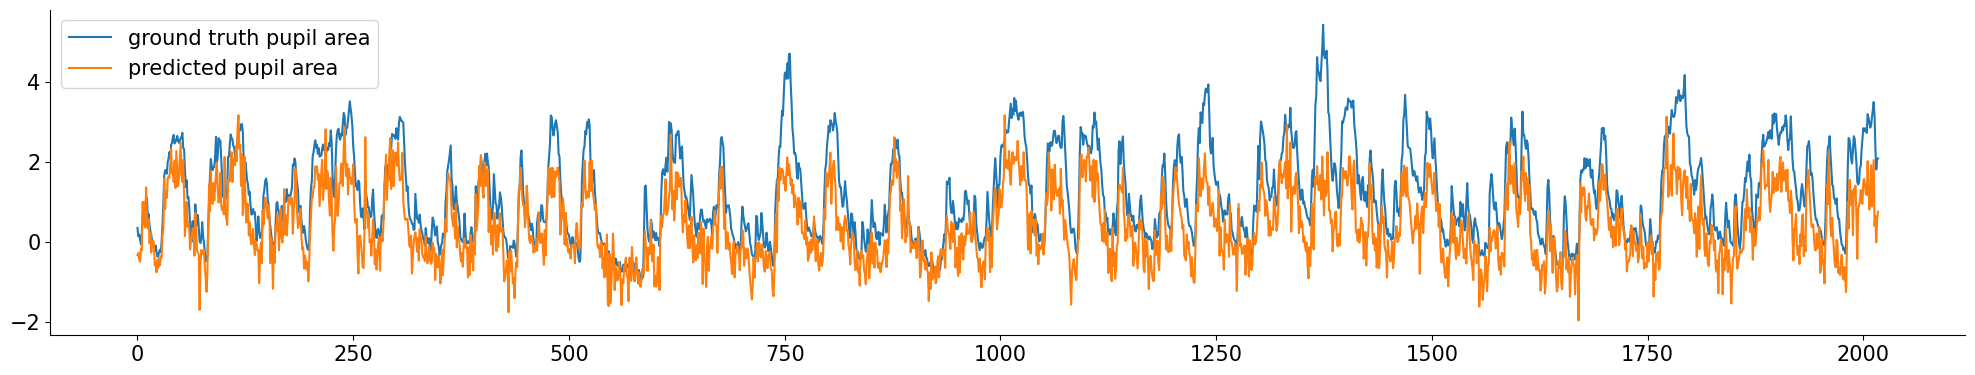

In [ ]:
pred_test_pupil_area = ridge_pupil_area_390.predict(test_neural_activity_390)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 360

In [ ]:
train_neural_activity_360 = neural_activity_360.T[0:5000]
train_neural_activity_360.shape

(5000, 1418)

In [ ]:
test_neural_activity_360 = neural_activity_360.T[5000:]
test_neural_activity_360.shape

(2018, 1418)

In [ ]:
ridge_decoder_pupilArea_360 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_360 = GridSearchCV(ridge_decoder_pupilArea_360,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_360.fit(train_neural_activity_360,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_360 = Ridge_pupil_area_gs_360.best_estimator_
ridge_pupil_area_360

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset (360):  0.8936967280031408


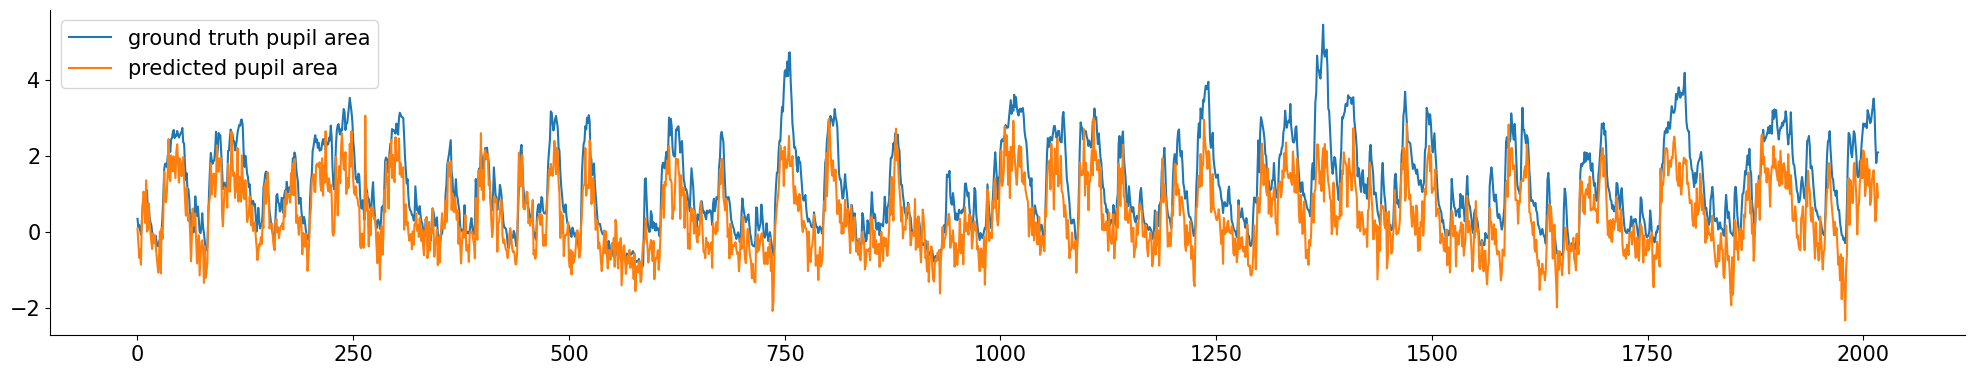

In [ ]:
pred_test_pupil_area = ridge_pupil_area_360.predict(test_neural_activity_360)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset (360): ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 330

In [ ]:
train_neural_activity_330 = neural_activity_330.T[0:5000]
train_neural_activity_330.shape

(5000, 1471)

In [ ]:
test_neural_activity_330 = neural_activity_330.T[5000:]
test_neural_activity_330.shape

(2018, 1471)

In [ ]:
ridge_decoder_pupilArea_330 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_330 = GridSearchCV(ridge_decoder_pupilArea_330,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_330.fit(train_neural_activity_330,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_330 = Ridge_pupil_area_gs_330.best_estimator_
ridge_pupil_area_330

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.8897411942590568


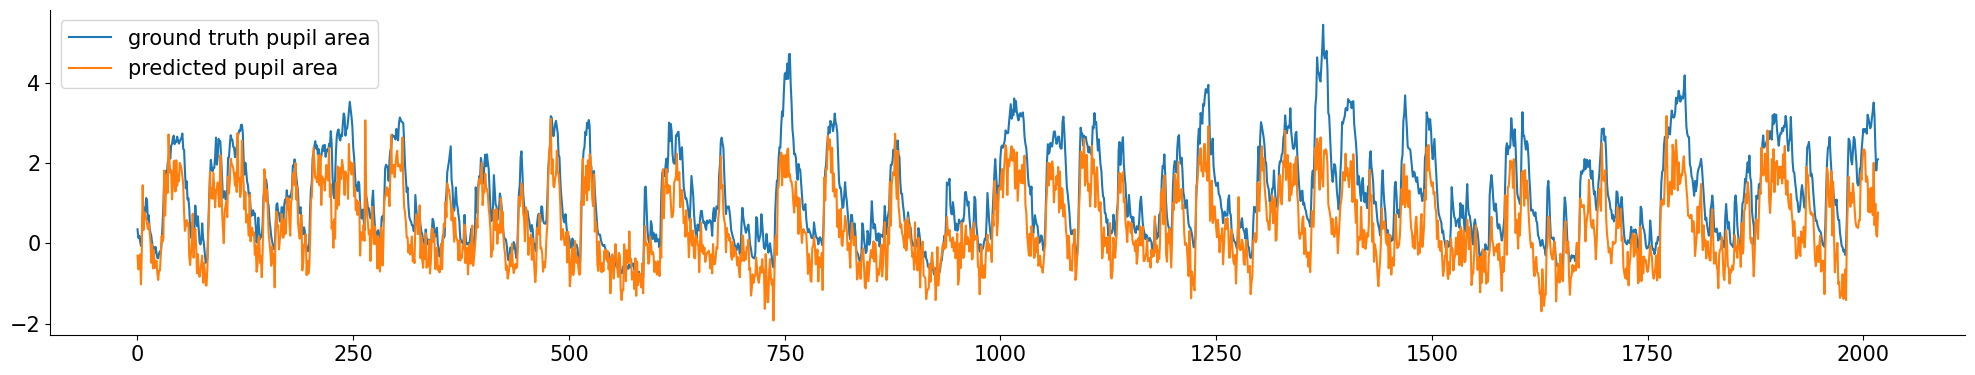

In [ ]:
pred_test_pupil_area = ridge_pupil_area_330.predict(test_neural_activity_330)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 300

In [ ]:
train_neural_activity_300 = neural_activity_300.T[0:5000]
train_neural_activity_300.shape

(5000, 1405)

In [ ]:
test_neural_activity_300 = neural_activity_300.T[5000:]
test_neural_activity_300.shape

(2018, 1405)

In [ ]:
ridge_decoder_pupilArea_300 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_300 = GridSearchCV(ridge_decoder_pupilArea_300,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_300.fit(train_neural_activity_300,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_300 = Ridge_pupil_area_gs_300.best_estimator_
ridge_pupil_area_300

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.9056728060760459


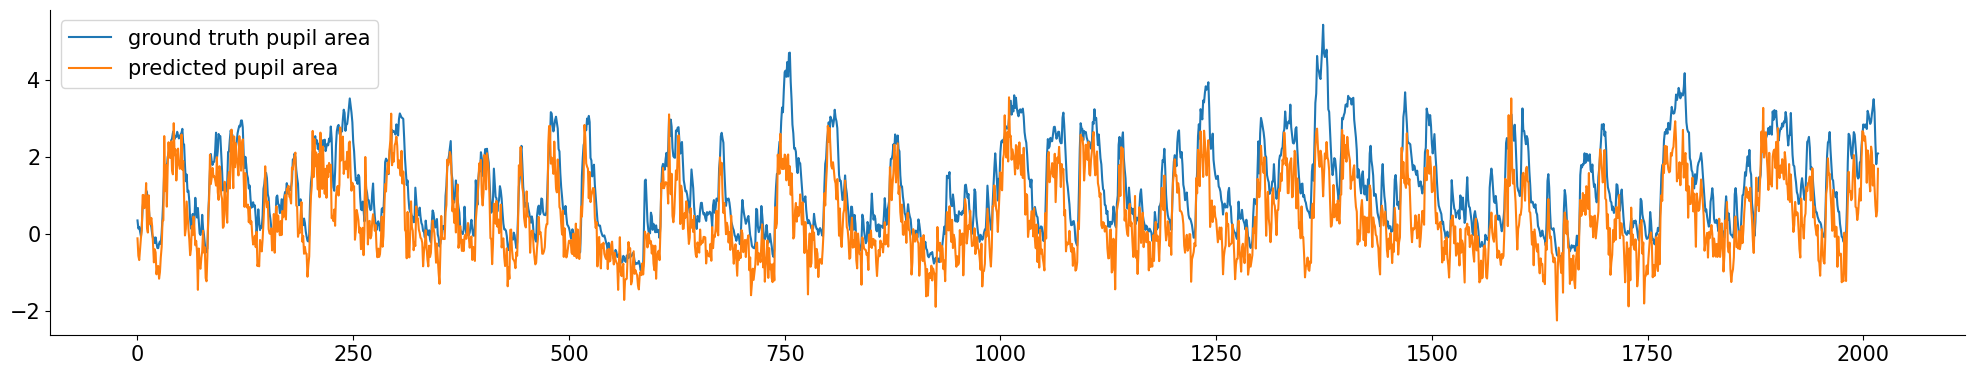

In [ ]:
pred_test_pupil_area = ridge_pupil_area_300.predict(test_neural_activity_300)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 270

In [ ]:
train_neural_activity_270 = neural_activity_270.T[0:5000]
train_neural_activity_270.shape

(5000, 1331)

In [ ]:
test_neural_activity_270 = neural_activity_270.T[5000:]
test_neural_activity_270.shape

(2018, 1331)

In [ ]:
ridge_decoder_pupilArea_270 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_270 = GridSearchCV(ridge_decoder_pupilArea_270,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_270.fit(train_neural_activity_270,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_270 = Ridge_pupil_area_gs_270.best_estimator_
ridge_pupil_area_270

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.928620335701669


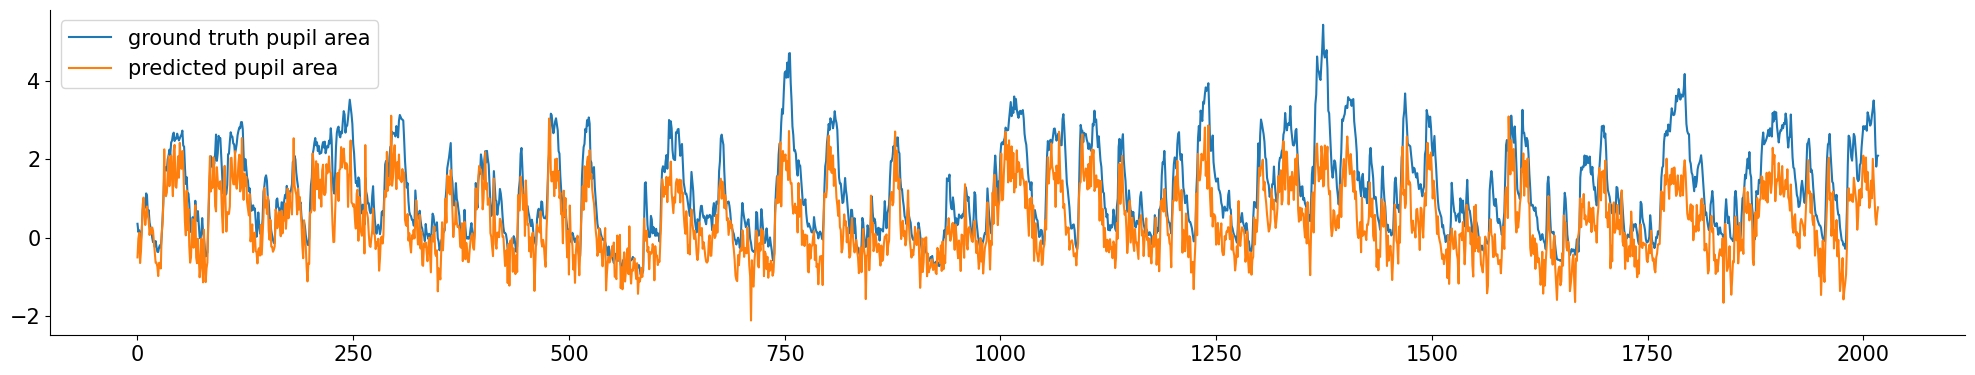

In [ ]:
pred_test_pupil_area = ridge_pupil_area_270.predict(test_neural_activity_270)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 240

In [ ]:
train_neural_activity_240 = neural_activity_240.T[0:5000]
train_neural_activity_240.shape

(5000, 1218)

In [ ]:
test_neural_activity_240 = neural_activity_240.T[5000:]
test_neural_activity_240.shape

(2018, 1218)

In [ ]:
ridge_decoder_pupilArea_240 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_240 = GridSearchCV(ridge_decoder_pupilArea_240,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_240.fit(train_neural_activity_240,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_240 = Ridge_pupil_area_gs_240.best_estimator_
ridge_pupil_area_240

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.039608420591259


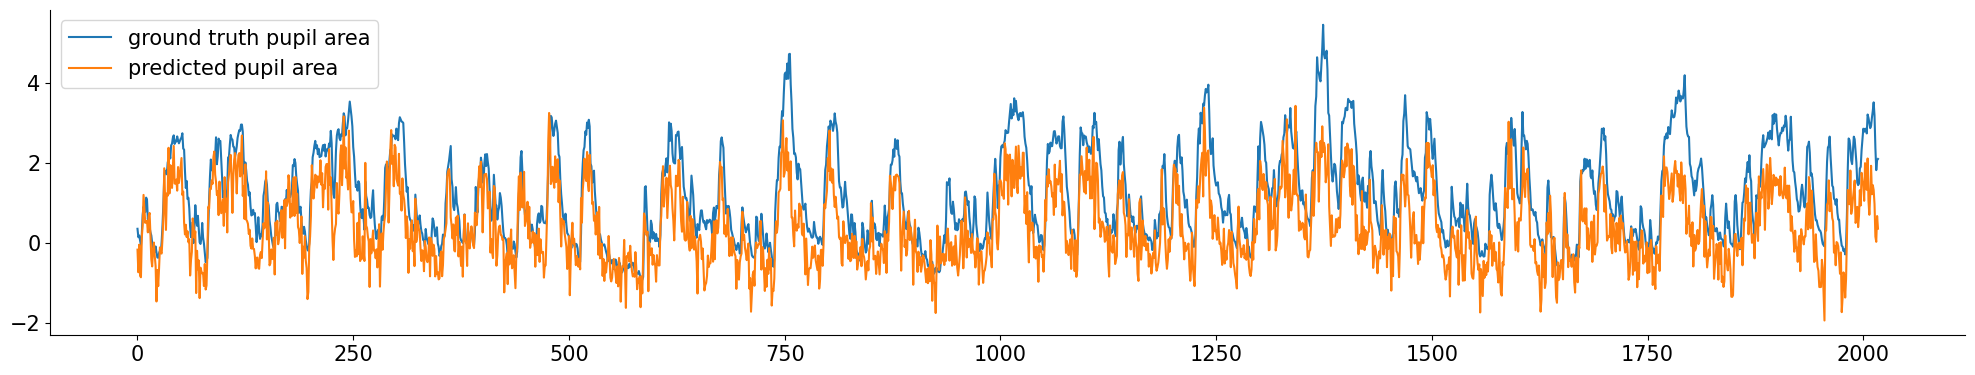

In [ ]:
pred_test_pupil_area = ridge_pupil_area_240.predict(test_neural_activity_240)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 210

In [ ]:
train_neural_activity_210 = neural_activity_210.T[0:5000]
train_neural_activity_210.shape

(5000, 1218)

In [ ]:
test_neural_activity_210 = neural_activity_210.T[5000:]
test_neural_activity_210.shape

(2018, 1218)

In [ ]:
ridge_decoder_pupilArea_210 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_210 = GridSearchCV(ridge_decoder_pupilArea_390,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_210.fit(train_neural_activity_210,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_210 = Ridge_pupil_area_gs_210.best_estimator_
ridge_pupil_area_210

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.039608420591259


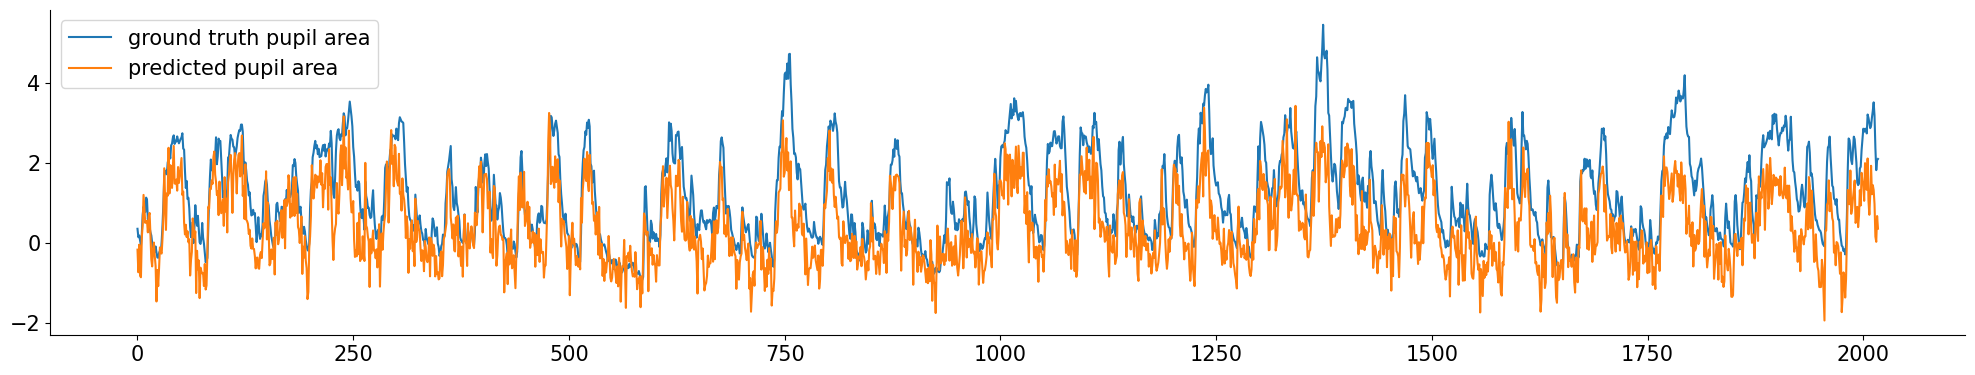

In [ ]:
pred_test_pupil_area = ridge_pupil_area_210.predict(test_neural_activity_210)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 180

In [ ]:
train_neural_activity_180 = neural_activity_180.T[0:5000]
train_neural_activity_180.shape

(5000, 1183)

In [ ]:
test_neural_activity_180 = neural_activity_180.T[5000:]
test_neural_activity_180.shape

(2018, 1183)

In [ ]:
ridge_decoder_pupilArea_180 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_180 = GridSearchCV(ridge_decoder_pupilArea_180,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_180.fit(train_neural_activity_180,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_180 = Ridge_pupil_area_gs_180.best_estimator_
ridge_pupil_area_180

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.1637470509901173


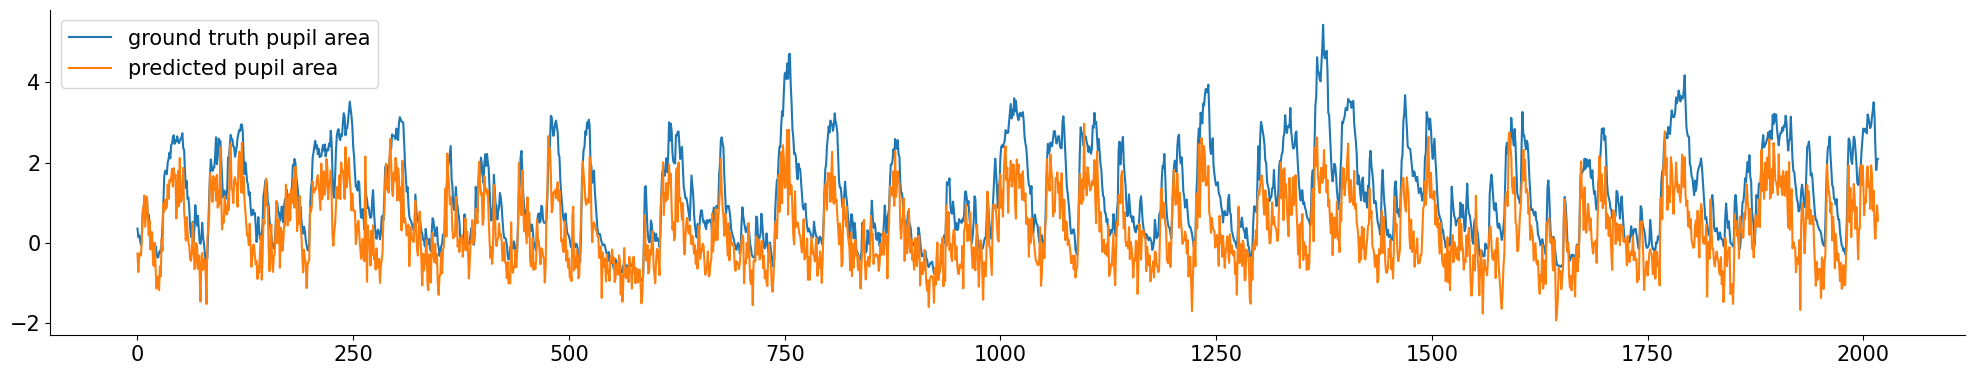

In [ ]:
pred_test_pupil_area = ridge_pupil_area_180.predict(test_neural_activity_180)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 150

In [ ]:
train_neural_activity_150 = neural_activity_150.T[0:5000]
train_neural_activity_150.shape

(5000, 1132)

In [ ]:
test_neural_activity_150 = neural_activity_150.T[5000:]
test_neural_activity_150.shape

(2018, 1132)

In [ ]:
ridge_decoder_pupilArea_150 = Pipeline([('Scaler',StandardScaler()),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_150 = GridSearchCV(ridge_decoder_pupilArea_150,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_150.fit(train_neural_activity_150,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_150 = Ridge_pupil_area_gs_150.best_estimator_
ridge_pupil_area_150

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.2780995116885496


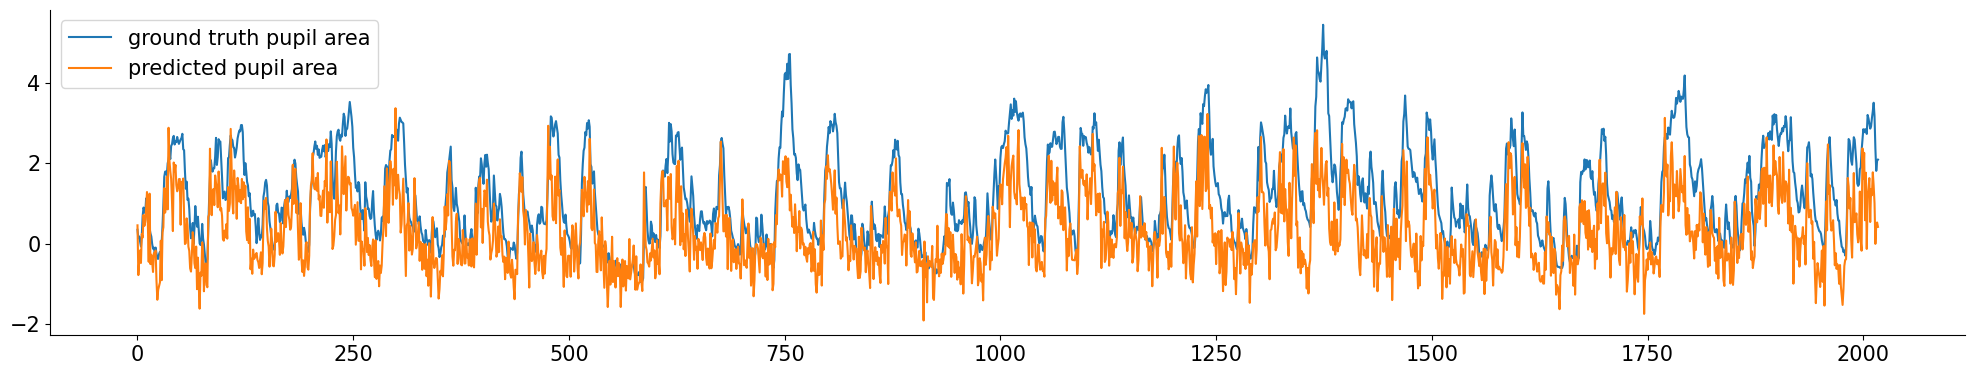

In [ ]:
pred_test_pupil_area = ridge_pupil_area_150.predict(test_neural_activity_150)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

# Something about eye position (PupilCOM)

### Data observation

In [ ]:
dat['pupilCOM'][0].shape

(2,)

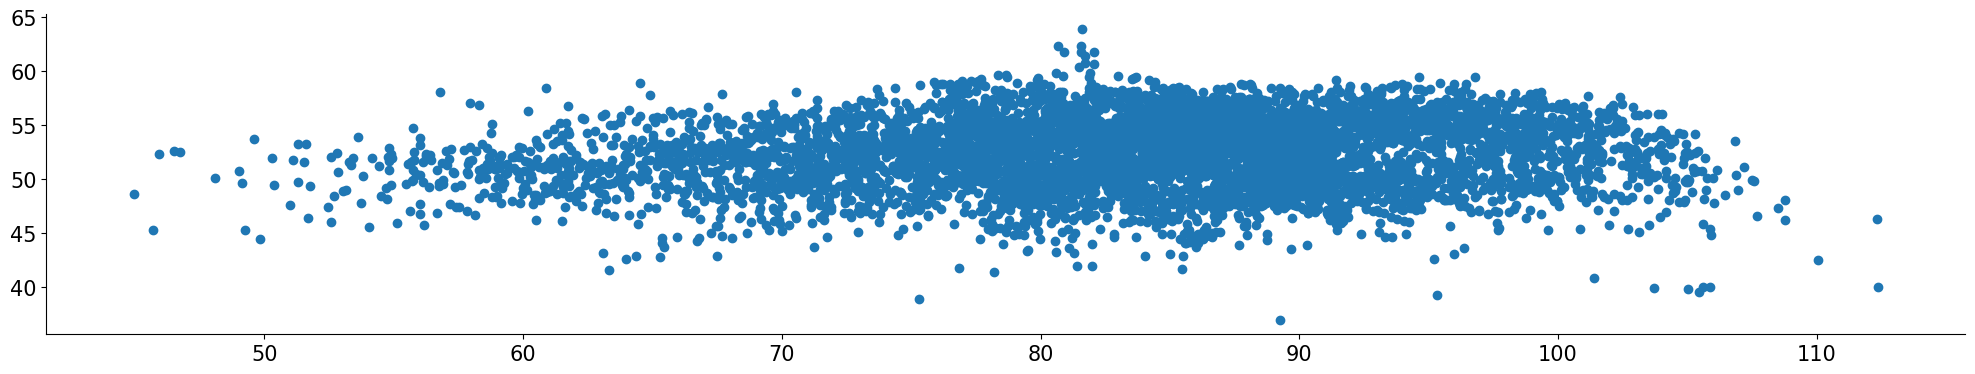

In [ ]:
plt.figure()
plt.scatter(dat['pupilCOM'][:,0],dat['pupilCOM'][:,1])

In [ ]:
train_pupil_positon = dat['pupilCOM'][0:5000]
pupil_position_flag = train_pupil_positon[:,0] + train_pupil_positon[:,1]

train_neural_activity_cleaning = train_neural_activity[~np.isnan(pupil_position_flag),:]
train_pupil_positon_cleaning = train_pupil_positon[~np.isnan(pupil_position_flag),:]

train_neural_activity_cleaning.shape, train_pupil_positon_cleaning.shape

((4986, 11983), (4986, 2))

In [ ]:
Scaler_positon = StandardScaler()
train_pupil_positon_cleaning = Scaler_positon.fit_transform(train_pupil_positon_cleaning)

In [ ]:
test_neural_activity = dat['sresp'][:,5000:].T
test_pupil_position = dat['pupilCOM'][5000:]

test_pupil_position_flag = test_pupil_position[:,0] + test_pupil_position[:,1]
test_pupil_position_flag.shape
test_pupil_position_cleaning = test_pupil_position[~np.isnan(test_pupil_position_flag),:]
test_neural_activity_cleaning = test_neural_activity[~np.isnan(test_pupil_position_flag),:]

test_neural_activity_cleaning.shape, test_pupil_position_cleaning.shape

((2015, 11983), (2015, 2))

In [ ]:
test_pupil_position_cleaning = Scaler_positon.transform(test_pupil_position_cleaning)

### Train a Linear Decoder with multiple output

In [ ]:
linear_decoder_pupilposition = Pipeline([('Scaler',StandardScaler()),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
multi_linear_regre = MultiOutputRegressor(linear_decoder_pupilposition)

In [ ]:
#train_pupil_positon[0]
multi_linear_regre = multi_linear_regre.fit(train_neural_activity_cleaning,train_pupil_positon_cleaning)

### Test on Training Dataset

In [ ]:
pred_train_position = multi_linear_regre.predict(train_neural_activity_cleaning)
pred_train_position.shape

(4986, 2)

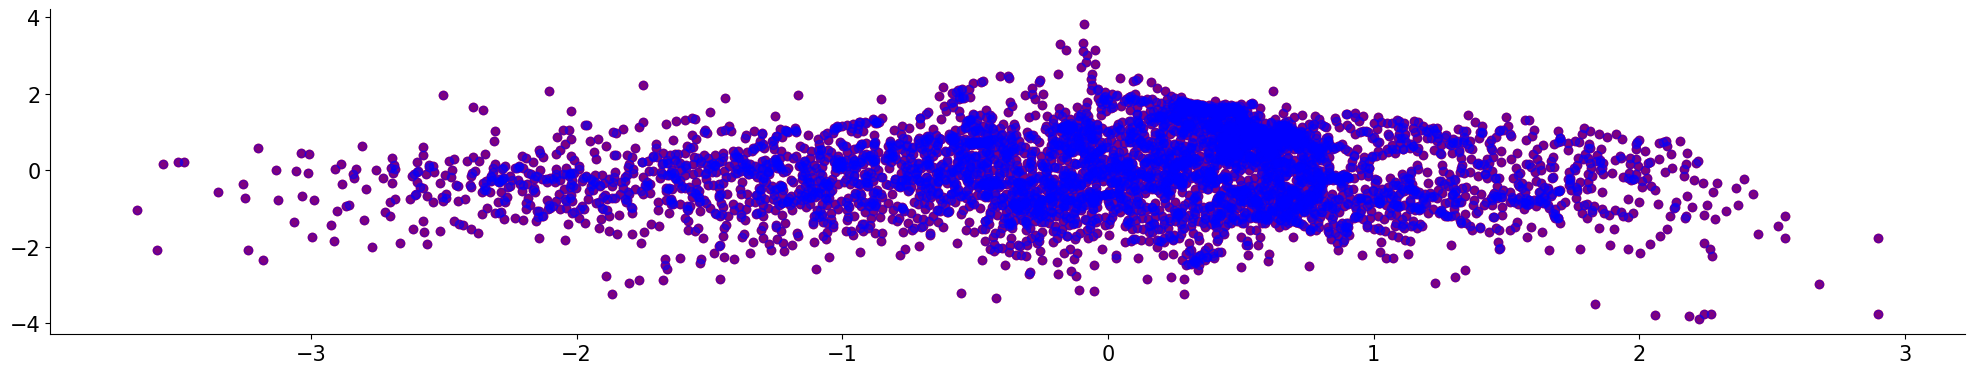

In [ ]:
plt.figure()
plt.scatter(train_pupil_positon_cleaning[:,0],train_pupil_positon_cleaning[:,1], c = 'r')
plt.scatter(pred_train_position[:,0],pred_train_position[:,1],c = 'b', alpha = 0.5)

MSE Formula:

$MSE = \frac{1}{n}\sum_{i=1}^n (x - {x}')^2 + (y - {y}')^2$

Where n is the total number of samples, x,y are the two-dimensional position, x',y' is predicted position.

In [ ]:
mse = np.sum((train_pupil_positon_cleaning - pred_train_position)**2)/train_pupil_positon_cleaning.shape[0]
print("the MSE in the training dataset is: ", mse)

the MSE in the training dataset is:  2.6026502878494474e-11


### test on testing dataset

In [ ]:
pred_test_position = multi_linear_regre.predict(test_neural_activity_cleaning)
test_pupil_position_cleaning.shape

(2015, 2)

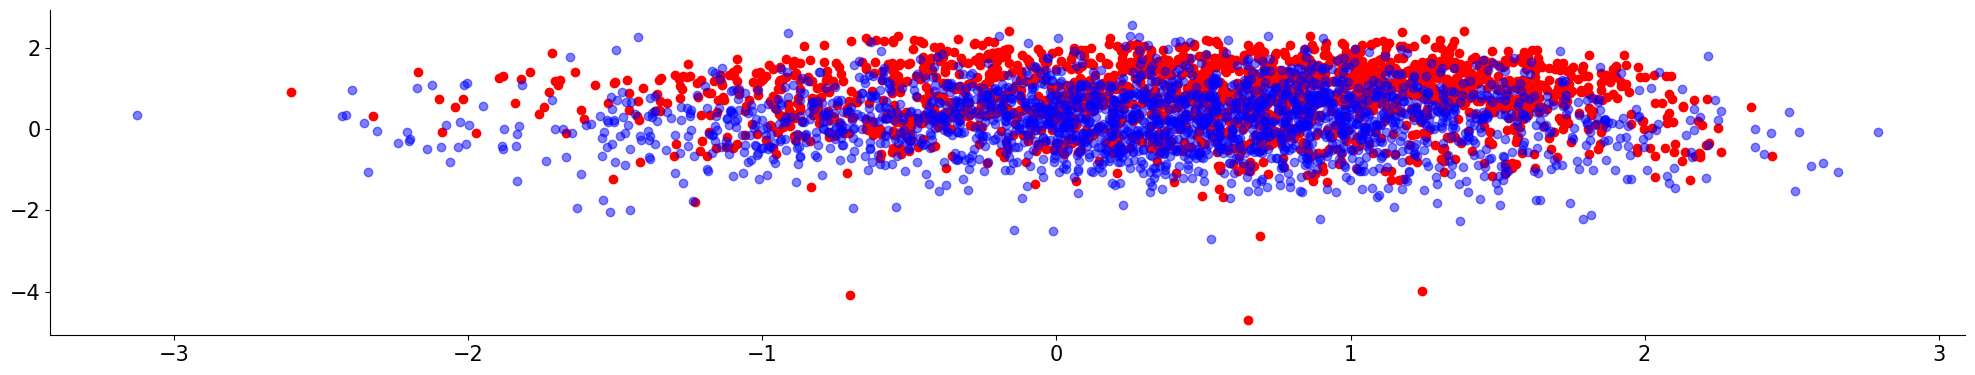

In [ ]:
plt.figure()
plt.scatter(test_pupil_position_cleaning[:,0],test_pupil_position_cleaning[:,1], c = 'r')
plt.scatter(pred_test_position[:,0],pred_test_position[:,1],c = 'b', alpha = 0.5)

In [ ]:
mse = np.sum((test_pupil_position_cleaning - pred_test_position)**2)/test_pupil_position_cleaning.shape[0]
print("the MSE in the training dataset is: ", mse)

the MSE in the training dataset is:  1.0657786078125304


# Motion energy

In [ ]:
dat['beh_svd_mask'].shape, dat['beh_svd_time'].shape

((240, 320, 1000), (7018, 1000))

In [ ]:
motion_eng = (dat['beh_svd_mask'] @ dat['beh_svd_time'].T)



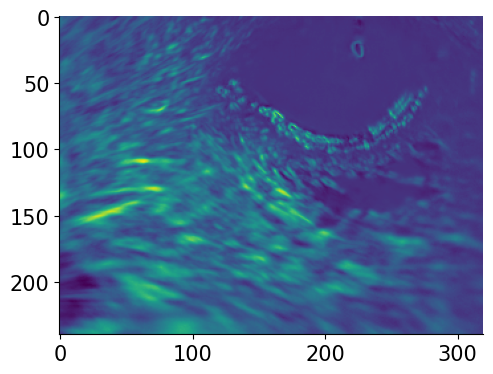

In [ ]:
plt.imshow(motion_eng[:,:,1])

In [ ]:
 dat['beh_svd_time'].shape

 train_behav = dat['beh_svd_time'][0:5000]
 test_behav = dat['beh_svd_time'][5000:]

In [ ]:
Scaler_behav = StandardScaler()
train_behav = Scaler_behav.fit_transform(train_behav)
test_behav = Scaler_behav.transform(test_behav)

## Linear

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
linear_decoder_behav = Pipeline([('Scaler',StandardScaler()),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
linear_decoder_behav.fit(train_neural_activity,train_behav)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('linear_regressor', LinearRegression())])

In [ ]:
pred_behav = linear_decoder_behav.predict(test_neural_activity)

In [ ]:
print("mse(behave): ", mean_squared_error(pred_behav, test_behav))

mse(behave):  2.0332821999753734


## Non-linear

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import kera

In [ ]:
train_neural_activity_scaled = linear_decoder_behav.named_steps['Scaler'].transform(train_neural_activity)

test_neural_activity_scaled = linear_decoder_behav.named_steps['Scaler'].transform(test_neural_activity)


In [ ]:
import tensorflow as tf

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (11983)),
    tf.keras.layers.Dense(100, activation='linear'),
    Dense(1000, activation='linear', name='output_layer')
])
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer = 'Adam',
                metrics = ['mse'])
model_1_history = model_1.fit(train_neural_activity_scaled,train_behav, epochs = 15, validation_split = 0.3)

Epoch 1/15
110/110 [==============================] - 5s 38ms/step - loss: 1.2144 - mse: 1.2144 - val_loss: 1.0453 - val_mse: 1.0453
Epoch 2/15
110/110 [==============================] - 5s 44ms/step - loss: 0.9466 - mse: 0.9466 - val_loss: 1.0578 - val_mse: 1.0578
Epoch 3/15
110/110 [==============================] - 2s 22ms/step - loss: 0.8398 - mse: 0.8398 - val_loss: 1.1212 - val_mse: 1.1212
Epoch 4/15
110/110 [==============================] - 2s 23ms/step - loss: 0.7715 - mse: 0.7715 - val_loss: 1.1683 - val_mse: 1.1683
Epoch 5/15
110/110 [==============================] - 2s 22ms/step - loss: 0.7395 - mse: 0.7395 - val_loss: 1.2026 - val_mse: 1.2026
Epoch 6/15
110/110 [==============================] - 3s 24ms/step - loss: 0.7210 - mse: 0.7210 - val_loss: 1.2121 - val_mse: 1.2121
Epoch 7/15
110/110 [==============================] - 3s 30ms/step - loss: 0.7149 - mse: 0.7149 - val_loss: 1.2163 - val_mse: 1.2163
Epoch 8/15
110/110 [==============================] - 2s 22ms/step - 

In [ ]:
model_1.evaluate(test_neural_activity_scaled,test_behav)

64/64 [==============================] - 0s 6ms/step - loss: 1.4103 - mse: 1.4103


[1.4102727174758911, 1.4102727174758911]

In [ ]:
key_names = list(model_1_history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(8,5))
for i in range(len(key_names)):
    plt.plot(model_1_history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend()
plt.title('Learning Curves', size=15);

AttributeError: ignored

In [ ]:
import tensorflow as tf

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (11983)),
    tf.keras.layers.Dense(100, activation='linear'),
    tf.keras.layers.Dense(100, activation='linear'),
    tf.keras.layers.Dense(100, activation='linear'),
    Dense(1000, activation='linear', name='output_layer')
])
model_2.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer = 'Adam',
                metrics = ['mse'])
model_1_history = model_1.fit(train_neural_activity_scaled,train_behav, epochs = 15, validation_split = 0.3)